In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython import display

In [2]:
def calculate_psi(x):
    return 0.5-np.amax(np.abs(np.abs(x)-0.5), axis=1)

def calculate_y(x, g_num):
    z = np.sign(x)
    z_list = []
    for row in z:
        #print(row.size)
        ind = 0
        for i in range(len(row)):
            if row[i] == 1:
                ind += 2**i
        z_list.append(g_num[ind])
    # ind = np.sum([digit * 2 ** i for i, digit in enumerate(row)])
    y = z_list * calculate_psi(x-z/2)
    return torch.FloatTensor(y)

In [3]:
learning_rate = 0.1
lambda_l2 = 1e-5

output_size = 1

loss_fn = nn.MSELoss()

models = []
gen_error = {} # d-n-gen_error

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
for d in range(5, 15, 3):
    gen_error[d] = {}
    for j in range(5, 14):
        n = 2**j
        gen_error_k = 0

        #x_train = torch.zeros([n, d]).uniform_(-1, 1)
        x_train = np.random.uniform(low=-1, high=1, size=(n,d)).astype('float32')
        
        #x_test = torch.zeros([n, d]).uniform_(-1, 1)
        x_test = np.random.uniform(low=-1, high=1, size=(n,d)).astype('float32')
        
        x_train_tensor = torch.from_numpy(x_train).to(device)
        x_test_tensor = torch.from_numpy(x_test).to(device)


        for k in range(10):
            np.random.seed(k)
            g_num = np.random.choice([-1,1], size=(2**d))
            y_train = calculate_y(x_train, g_num).to(device)
            y_test = calculate_y(x_test, g_num).to(device)

            n_1st = 32
            n_2nd = 32
            model = nn.Sequential(
                nn.Linear(d, n_1st),
                nn.ReLU(),
                nn.Linear(n_1st, n_2nd),
                nn.ReLU(),
                nn.Linear(n_2nd, output_size),
            )
            model.to(device)
            models.append(model)

            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

            loss = 0
            for t in range(150):
                y_pred = model(x_train_tensor)
                loss = loss_fn(y_pred, y_train)
                if loss - 0 <= 1e-4:
                    break
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"[MODEL]: g_{k}, [d]: {d}, [n]: {n}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
            display.clear_output(wait=True)
            with torch.no_grad():
                y_pred = model(x_test_tensor)
            gen_error_k += loss_fn(y_pred, y_test) / y_test.std().item()
        gen_error[d][j] = gen_error_k / 10

[MODEL]: g_9, [d]: 14, [n]: 8192, [EPOCH]: 149, [LOSS]: 0.002664


In [7]:
gen_error

{5: {5: tensor(0.1240, device='cuda:0'),
  6: tensor(0.1221, device='cuda:0'),
  7: tensor(0.1207, device='cuda:0'),
  8: tensor(0.1117, device='cuda:0'),
  9: tensor(0.1112, device='cuda:0'),
  10: tensor(0.1119, device='cuda:0'),
  11: tensor(0.1124, device='cuda:0'),
  12: tensor(0.1100, device='cuda:0'),
  13: tensor(0.1102, device='cuda:0')},
 8: {5: tensor(0.0787, device='cuda:0'),
  6: tensor(0.0941, device='cuda:0'),
  7: tensor(0.0791, device='cuda:0'),
  8: tensor(0.0810, device='cuda:0'),
  9: tensor(0.0791, device='cuda:0'),
  10: tensor(0.0777, device='cuda:0'),
  11: tensor(0.0810, device='cuda:0'),
  12: tensor(0.0798, device='cuda:0'),
  13: tensor(0.0800, device='cuda:0')},
 11: {5: tensor(0.0738, device='cuda:0'),
  6: tensor(0.0666, device='cuda:0'),
  7: tensor(0.0667, device='cuda:0'),
  8: tensor(0.0639, device='cuda:0'),
  9: tensor(0.0612, device='cuda:0'),
  10: tensor(0.0628, device='cuda:0'),
  11: tensor(0.0642, device='cuda:0'),
  12: tensor(0.0655, device=

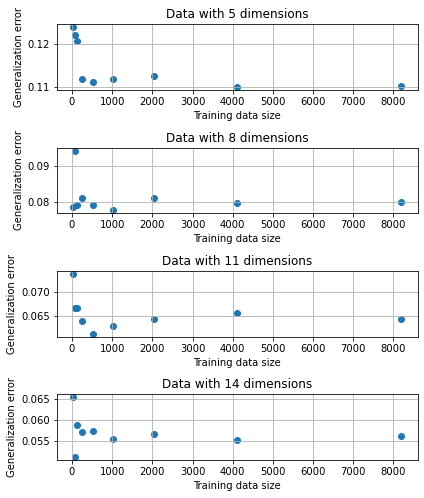

In [21]:
import matplotlib.pyplot as plt

d_range = list(range(5, 15, 3))
figure, axis = plt.subplots(len(gen_error), figsize=(6,7))
for d in range(len(d_range)):
    x = []
    y = []
    for key, val in gen_error[d_range[d]].items():
        x.append(2**key)
        y.append(val.detach().cpu().numpy())
    axis[d].grid()
    axis[d].scatter(x, y)
    axis[d].set_title(f'Data with {d_range[d]} dimensions')
    axis[d].set_xlabel('Training data size')
    axis[d].set_ylabel('Generalization error')
figure.tight_layout()
figure.savefig("problem_14.png")